In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import sys
import scipy.io
from concurrent.futures import ProcessPoolExecutor

# Get path 
# Get path to MCMCwithODEs_primer (3 levels up)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)




In [2]:
import sys
sys.path.append('./..')  # or absolute path if needed

from invode import ODEOptimizer, lhs_sample, load_matlab_data

In [3]:
file_path = './../sample_data/HS6_13-15_2024.mat' 
free_phages = load_matlab_data(file_path)['free_phages']
S0 = np.mean(load_matlab_data(file_path)['S0_replicates'])
V0 = np.mean(load_matlab_data(file_path)['V0_replicates'])
time = load_matlab_data(file_path)['time_free_phages'].flatten()/60  # Convert time to hours

# Initial guess for parameters ===
initial_guess = {
    'r': 0.25,
    'phi': 4.5e-08 ,
    'beta':  256,
    'tau': 2,
    'NE': 180
}


# Initial conditions ===
y0 = np.zeros((initial_guess['NE']+3,))
y0[0] = S0
y0[-1] = V0



In [4]:
def onstep(y, t, params):

    phi = params['phi']
    beta = params['beta']
    tau = params['tau']
    r = params['r']
    NE = params['NE']

    S = y[0]
    E_mat = y[1:NE+1]
    I = y[NE+1]
    V = y[NE+2]

    etaeff = ((NE+1)/tau)

    dotS = r*S - phi*V*S
    dotE1 = phi*S*V - etaeff * E_mat[0]
    
    if NE > 1:
        dotE_mat = np.zeros(NE-1)
        dotE_mat[:] = etaeff * E_mat[0:-1] - etaeff * E_mat[1:]

    dotI = etaeff * (E_mat[-1] - I)
    dotV = beta * etaeff * I - V * phi * (S + I + np.sum(E_mat))

    # Build the full derivative vector (same length as y)
    dydt = np.zeros_like(y)
    dydt[0] = dotS
    dydt[1:NE+1] = dotE1 if NE == 1 else np.concatenate([[dotE1], dotE_mat])
    dydt[NE+1] = dotI
    dydt[NE+2] = dotV

    return dydt



In [5]:
def simulate_model(params):
    # Initial conditions ===
    params['NE'] = int(params['NE'])
    y0 = np.zeros((params['NE']+3,))
    y0[0] = S0
    y0[-1] = V0


    ## dilution step
    time_dil = np.linspace(0, 0.25, 200)  # Short time for dilution step
    sol_dil = odeint(onstep, y0, time_dil, args=(params,))
    y0_dil = sol_dil[-1, :]/100 # Use the last state as the new initial condition
    ## main simulation
    sol = odeint(onstep, y0_dil, time, args=(params,))
    phage_solution = sol[:,-1]
    return phage_solution 



In [6]:
def mse(model_output):
    target = np.mean(free_phages, axis=1)
    if len(model_output) != len(target):
        raise ValueError("Length mismatch between model output and data")
    return np.mean((np.log10(model_output) - np.log10(target)) ** 2)


In [7]:
free_phages_sol = simulate_model(initial_guess)

In [8]:
param_bounds={
            'r': (0.1, 0.5),
            'phi': (1e-8, 1e-7),
            'beta': (100, 500),
            'tau': (1, 5),
            'NE': (100, 200)
        }


optimizer = ODEOptimizer(
    ode_func=simulate_model,
    error_func=mse,
    param_bounds=param_bounds,
    initial_guess=initial_guess,
    seed=42,
    num_top_candidates=2,
    n_samples=300,
    num_iter=10
)



In [9]:

optimizer.fit()


Shrinking Search Progress: 100%|████████████████████████████████████████| 10/10 [01:20<00:00,  8.07s/it]


({'r': 0.41342068901106066,
  'phi': 6.733997357832918e-08,
  'beta': 412.530995387369,
  'tau': 1.9816198718607785,
  'NE': 151.0},
 0.0025495983615502387)

In [14]:
best_params = optimizer.best_params


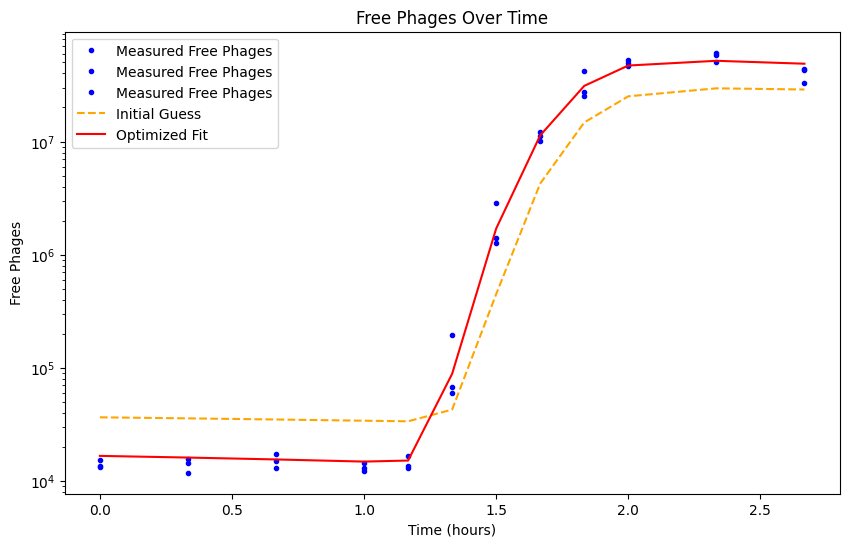

In [17]:
phages_fit = simulate_model(best_params)


plt.figure(figsize=(10, 6))
plt.plot(time, free_phages, label='Measured Free Phages', color='blue', marker='o', markersize=3, linestyle='none')
plt.plot(time, free_phages_sol, label='Initial Guess', linestyle='--', color='orange')
plt.plot(time, phages_fit, label='Optimized Fit', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Free Phages')
plt.yscale('log')
plt.title('Free Phages Over Time')
plt.legend()
plt.show()